In [0]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Activation, Lambda, Add
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'dogs_32/train/'
#validation_dir = 'dogs/validation/'
test_dir = 'dogs_32/test/'

STD_SIZE = (32, 32)
BATCH_SIZE = 128
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

In [30]:
def lr_scheduler(epoch):
    x = 1e-3
    if epoch >= 50: x /= 10.0
    if epoch >= 100: x /= 10.0
    if epoch >= 150: x /= 10.0
    return x

# Data preparation

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 269 images belonging to 2 classes.
Found 68 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (68, 32, 32, 3)


# Baseline

## Model

In [39]:
inputs = Input(shape=(32, 32, 3))
conv = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
conv = Conv2D(64, (3, 3), activation='relu', padding='same')(conv)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(128, (3, 3), activation='relu', padding='same')(pool)
conv = Conv2D(128, (3, 3), activation='relu', padding='same')(conv)
pool = MaxPooling2D(pool_size=(2, 2))(conv)

flat = Flatten()(pool)
outputs = Dense(512, activation='relu')(flat)
outputs = Dense(len(classes_labels), activation='softmax')(outputs)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + '7_layers_dogs_alpha_0_test', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

with open(PATH + '7_layers_dogs_alpha_0_history_test', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/200
 - 182s - loss: 4.7646 - acc: 0.0145 - val_loss: 4.6348 - val_acc: 0.0293

Epoch 00001: val_acc improved from -inf to 0.02930, saving model to 7_layers_dogs_alpha_0_test
Epoch 2/200
 - 12s - loss: 4.6042 - acc: 0.0252 - val_loss: 4.6073 - val_acc: 0.0283

Epoch 00002: val_acc did not improve from 0.02930
Epoch 3/200
 - 12s - loss: 4.5017 - acc: 0.0325 - val_loss: 4.3920 - val_acc: 0.0454

Epoch 00003: val_acc improved from 0.02930 to 0.04536, saving model to 7_layers_dogs_alpha_0_test
Epoch 4/200
 - 13s - loss: 4.4239 - acc: 0.0408 - val_loss: 4.3431 - val_acc: 0.0473

Epoch 00004: val_acc improved from 0.04536 to 0.04735, saving model to 7_layers_dogs_alpha_0_test
Epoch 5/200
 - 12s - loss: 4.3480 - acc: 0.0505 - val_loss: 4.7968 - val_acc: 0.0263

Epoch 00005: val_acc did not improve from 0.04735
Epoch 6/200
 - 13s - loss: 4.2941 - acc: 0.0554 - val_loss: 4.2557 - val_acc: 0.0578

Epoch 00006: val_acc improved from 0.04735 to 0.05776, saving model to 7_layers_dogs_alpha_0


Epoch 00055: val_acc improved from 0.15072 to 0.15592, saving model to 7_layers_dogs_alpha_0_test
Epoch 56/200
 - 13s - loss: 2.3133 - acc: 0.4088 - val_loss: 4.6780 - val_acc: 0.1403

Epoch 00056: val_acc did not improve from 0.15592
Epoch 57/200
 - 13s - loss: 2.2883 - acc: 0.4167 - val_loss: 4.6529 - val_acc: 0.1554

Epoch 00057: val_acc did not improve from 0.15592
Epoch 58/200
 - 13s - loss: 2.2768 - acc: 0.4147 - val_loss: 4.7185 - val_acc: 0.1497

Epoch 00058: val_acc did not improve from 0.15592
Epoch 59/200
 - 14s - loss: 2.2719 - acc: 0.4131 - val_loss: 4.7207 - val_acc: 0.1485

Epoch 00059: val_acc did not improve from 0.15592
Epoch 60/200
 - 13s - loss: 2.2587 - acc: 0.4185 - val_loss: 4.6496 - val_acc: 0.1542

Epoch 00060: val_acc did not improve from 0.15592
Epoch 61/200
 - 14s - loss: 2.2541 - acc: 0.4201 - val_loss: 4.6344 - val_acc: 0.1532

Epoch 00061: val_acc did not improve from 0.15592
Epoch 62/200
 - 14s - loss: 2.2487 - acc: 0.4215 - val_loss: 4.7043 - val_acc: 

 - 13s - loss: 1.9466 - acc: 0.4862 - val_loss: 5.0507 - val_acc: 0.1537

Epoch 00115: val_acc did not improve from 0.15592
Epoch 116/200
 - 13s - loss: 1.9542 - acc: 0.4915 - val_loss: 5.1840 - val_acc: 0.1487

Epoch 00116: val_acc did not improve from 0.15592
Epoch 117/200
 - 13s - loss: 1.9862 - acc: 0.4799 - val_loss: 5.0305 - val_acc: 0.1544

Epoch 00117: val_acc did not improve from 0.15592
Epoch 118/200
 - 13s - loss: 1.9594 - acc: 0.4836 - val_loss: 5.0828 - val_acc: 0.1616

Epoch 00118: val_acc improved from 0.15592 to 0.16163, saving model to 7_layers_dogs_alpha_0_test
Epoch 119/200
 - 13s - loss: 1.9528 - acc: 0.4877 - val_loss: 5.1052 - val_acc: 0.1502

Epoch 00119: val_acc did not improve from 0.16163
Epoch 120/200
 - 13s - loss: 1.9635 - acc: 0.4868 - val_loss: 5.0871 - val_acc: 0.1539

Epoch 00120: val_acc did not improve from 0.16163
Epoch 121/200
 - 13s - loss: 1.9636 - acc: 0.4851 - val_loss: 5.0457 - val_acc: 0.1515

Epoch 00121: val_acc did not improve from 0.16163


 - 12s - loss: 1.9486 - acc: 0.4875 - val_loss: 5.1422 - val_acc: 0.1544

Epoch 00174: val_acc did not improve from 0.16634
Epoch 175/200
 - 12s - loss: 1.9356 - acc: 0.4897 - val_loss: 5.0913 - val_acc: 0.1584

Epoch 00175: val_acc did not improve from 0.16634
Epoch 176/200
 - 12s - loss: 1.9360 - acc: 0.4934 - val_loss: 5.1643 - val_acc: 0.1497

Epoch 00176: val_acc did not improve from 0.16634
Epoch 177/200
 - 12s - loss: 1.9511 - acc: 0.4890 - val_loss: 5.1254 - val_acc: 0.1544

Epoch 00177: val_acc did not improve from 0.16634
Epoch 178/200
 - 13s - loss: 1.9362 - acc: 0.4936 - val_loss: 5.1220 - val_acc: 0.1552

Epoch 00178: val_acc did not improve from 0.16634
Epoch 179/200
 - 12s - loss: 1.9170 - acc: 0.4976 - val_loss: 5.1414 - val_acc: 0.1554

Epoch 00179: val_acc did not improve from 0.16634
Epoch 180/200
 - 12s - loss: 1.9242 - acc: 0.4914 - val_loss: 5.0994 - val_acc: 0.1510

Epoch 00180: val_acc did not improve from 0.16634
Epoch 181/200
 - 12s - loss: 1.9358 - acc: 0.493

## Results

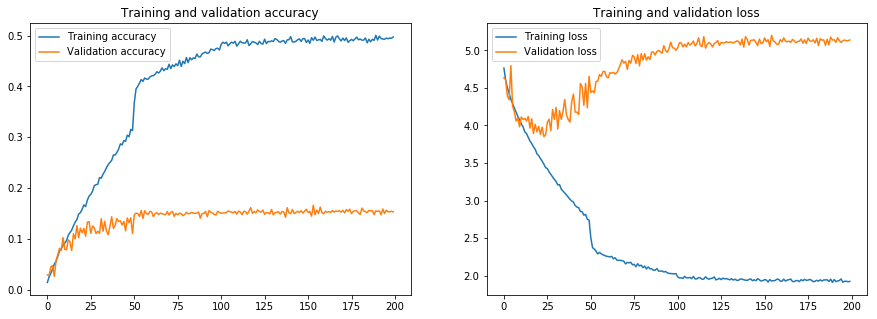

In [41]:
plot_accuracy_and_loss(history.history)

In [42]:
model = load_model(PATH + '7_layers_dogs_alpha_0_test')
model.evaluate(test_features, test_labels)

4162/4162 [==============================] - 1s 229us/step


[5.121671586698892, 0.154252763094666]

For alpha = 0:
 Max test accuracy = 0.1663



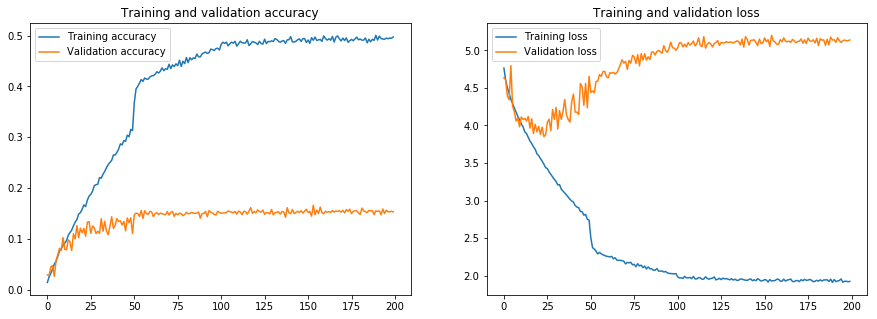

In [44]:
with open(PATH + '7_layers_dogs_alpha_0_history_test', 'rb') as f:
    history = pickle.load(f)
    print(f"For alpha = 0:\n Max test accuracy = {max(history['val_acc']):.04}\n")

plot_accuracy_and_loss(history)

# OctConv

In [46]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=32, alpha=alpha)([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=128, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)

    high = Conv2D(128, 3, padding='same')(high)
    low = Conv2D(128, 3, padding='same')(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    flat = Flatten()(x)
    outputs = Dense(512, activation='relu')(flat)
    outputs = Dense(120, activation='softmax')(outputs)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-3),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'7_layers_dogs_alpha_{alpha}_test', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

    with open(PATH + f'7_layers_dogs_alpha_{alpha}_history_test', 'wb') as f:
        pickle.dump(history.history, f)

Epoch 1/100
 - 14s - loss: 4.7372 - acc: 0.0154 - val_loss: 4.6009 - val_acc: 0.0248

Epoch 00001: val_acc improved from -inf to 0.02479, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 2/100
 - 12s - loss: 4.5906 - acc: 0.0259 - val_loss: 4.4596 - val_acc: 0.0307

Epoch 00002: val_acc improved from 0.02479 to 0.03074, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 3/100
 - 13s - loss: 4.4888 - acc: 0.0348 - val_loss: 4.3841 - val_acc: 0.0404

Epoch 00003: val_acc improved from 0.03074 to 0.04041, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 4/100
 - 12s - loss: 4.4166 - acc: 0.0389 - val_loss: 4.2932 - val_acc: 0.0459

Epoch 00004: val_acc improved from 0.04041 to 0.04586, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 5/100
 - 12s - loss: 4.3440 - acc: 0.0479 - val_loss: 4.2350 - val_acc: 0.0568

Epoch 00005: val_acc improved from 0.04586 to 0.05677, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 6/100
 - 12s - loss: 4.2908 - acc: 0.0552 - val_loss: 4.1

 - 12s - loss: 2.5460 - acc: 0.3613 - val_loss: 4.3503 - val_acc: 0.1448

Epoch 00053: val_acc did not improve from 0.14849
Epoch 54/100
 - 12s - loss: 2.4989 - acc: 0.3697 - val_loss: 4.4421 - val_acc: 0.1445

Epoch 00054: val_acc did not improve from 0.14849
Epoch 55/100
 - 12s - loss: 2.4820 - acc: 0.3692 - val_loss: 4.3517 - val_acc: 0.1455

Epoch 00055: val_acc did not improve from 0.14849
Epoch 56/100
 - 12s - loss: 2.4975 - acc: 0.3690 - val_loss: 4.3499 - val_acc: 0.1520

Epoch 00056: val_acc improved from 0.14849 to 0.15196, saving model to 7_layers_dogs_alpha_0.125_test
Epoch 57/100
 - 12s - loss: 2.4477 - acc: 0.3827 - val_loss: 4.4164 - val_acc: 0.1401

Epoch 00057: val_acc did not improve from 0.15196
Epoch 58/100
 - 12s - loss: 2.4423 - acc: 0.3831 - val_loss: 4.5381 - val_acc: 0.1401

Epoch 00058: val_acc did not improve from 0.15196
Epoch 59/100
 - 12s - loss: 2.4286 - acc: 0.3824 - val_loss: 4.5119 - val_acc: 0.1463

Epoch 00059: val_acc did not improve from 0.15196
Ep


Epoch 00009: val_acc improved from 0.08304 to 0.08850, saving model to 7_layers_dogs_alpha_0.25_test
Epoch 10/100
 - 13s - loss: 4.0841 - acc: 0.0850 - val_loss: 4.1568 - val_acc: 0.0744

Epoch 00010: val_acc did not improve from 0.08850
Epoch 11/100
 - 12s - loss: 4.0503 - acc: 0.0861 - val_loss: 4.0728 - val_acc: 0.0869

Epoch 00011: val_acc did not improve from 0.08850
Epoch 12/100
 - 12s - loss: 4.0118 - acc: 0.0939 - val_loss: 4.0130 - val_acc: 0.0905

Epoch 00012: val_acc improved from 0.08850 to 0.09048, saving model to 7_layers_dogs_alpha_0.25_test
Epoch 13/100
 - 12s - loss: 3.9696 - acc: 0.1003 - val_loss: 4.0578 - val_acc: 0.0890

Epoch 00013: val_acc did not improve from 0.09048
Epoch 14/100
 - 12s - loss: 3.9216 - acc: 0.1075 - val_loss: 3.9871 - val_acc: 0.0932

Epoch 00014: val_acc improved from 0.09048 to 0.09321, saving model to 7_layers_dogs_alpha_0.25_test
Epoch 15/100
 - 13s - loss: 3.8837 - acc: 0.1098 - val_loss: 4.0762 - val_acc: 0.1014

Epoch 00015: val_acc imp

 - 12s - loss: 2.3590 - acc: 0.3967 - val_loss: 4.6235 - val_acc: 0.1477

Epoch 00065: val_acc improved from 0.14725 to 0.14774, saving model to 7_layers_dogs_alpha_0.25_test
Epoch 66/100
 - 13s - loss: 2.3335 - acc: 0.4080 - val_loss: 4.6031 - val_acc: 0.1376

Epoch 00066: val_acc did not improve from 0.14774
Epoch 67/100
 - 12s - loss: 2.3269 - acc: 0.4081 - val_loss: 4.5575 - val_acc: 0.1477

Epoch 00067: val_acc did not improve from 0.14774
Epoch 68/100
 - 12s - loss: 2.3191 - acc: 0.4085 - val_loss: 4.6741 - val_acc: 0.1408

Epoch 00068: val_acc did not improve from 0.14774
Epoch 69/100
 - 12s - loss: 2.3407 - acc: 0.4029 - val_loss: 4.6379 - val_acc: 0.1450

Epoch 00069: val_acc did not improve from 0.14774
Epoch 70/100
 - 12s - loss: 2.2997 - acc: 0.4199 - val_loss: 4.7920 - val_acc: 0.1418

Epoch 00070: val_acc did not improve from 0.14774
Epoch 71/100
 - 12s - loss: 2.3292 - acc: 0.4074 - val_loss: 4.6905 - val_acc: 0.1341

Epoch 00071: val_acc did not improve from 0.14774
Epo


Epoch 00020: val_acc did not improve from 0.10089
Epoch 21/100
 - 12s - loss: 3.8074 - acc: 0.1264 - val_loss: 4.0919 - val_acc: 0.1066

Epoch 00021: val_acc improved from 0.10089 to 0.10659, saving model to 7_layers_dogs_alpha_0.5_test
Epoch 22/100
 - 12s - loss: 3.7545 - acc: 0.1362 - val_loss: 4.0126 - val_acc: 0.0984

Epoch 00022: val_acc did not improve from 0.10659
Epoch 23/100
 - 12s - loss: 3.7214 - acc: 0.1363 - val_loss: 4.1062 - val_acc: 0.0920

Epoch 00023: val_acc did not improve from 0.10659
Epoch 24/100
 - 12s - loss: 3.7048 - acc: 0.1417 - val_loss: 4.1752 - val_acc: 0.0994

Epoch 00024: val_acc did not improve from 0.10659
Epoch 25/100
 - 12s - loss: 3.6760 - acc: 0.1444 - val_loss: 4.0660 - val_acc: 0.1093

Epoch 00025: val_acc improved from 0.10659 to 0.10932, saving model to 7_layers_dogs_alpha_0.5_test
Epoch 26/100
 - 12s - loss: 3.6483 - acc: 0.1493 - val_loss: 4.0535 - val_acc: 0.1051

Epoch 00026: val_acc did not improve from 0.10932
Epoch 27/100
 - 12s - loss:


Epoch 00078: val_acc did not improve from 0.12891
Epoch 79/100
 - 12s - loss: 2.4542 - acc: 0.3827 - val_loss: 4.9642 - val_acc: 0.1185

Epoch 00079: val_acc did not improve from 0.12891
Epoch 80/100
 - 12s - loss: 2.4602 - acc: 0.3766 - val_loss: 4.9267 - val_acc: 0.1200

Epoch 00080: val_acc did not improve from 0.12891
Epoch 81/100
 - 12s - loss: 2.4420 - acc: 0.3872 - val_loss: 4.9781 - val_acc: 0.1235

Epoch 00081: val_acc did not improve from 0.12891
Epoch 82/100
 - 12s - loss: 2.4153 - acc: 0.3864 - val_loss: 4.8029 - val_acc: 0.1282

Epoch 00082: val_acc did not improve from 0.12891
Epoch 83/100
 - 12s - loss: 2.4384 - acc: 0.3820 - val_loss: 5.0929 - val_acc: 0.1150

Epoch 00083: val_acc did not improve from 0.12891
Epoch 84/100
 - 12s - loss: 2.4433 - acc: 0.3841 - val_loss: 4.8715 - val_acc: 0.1287

Epoch 00084: val_acc did not improve from 0.12891
Epoch 85/100
 - 12s - loss: 2.4297 - acc: 0.3899 - val_loss: 4.9538 - val_acc: 0.1200

Epoch 00085: val_acc did not improve fro

 - 12s - loss: 3.4351 - acc: 0.1841 - val_loss: 4.1301 - val_acc: 0.1108

Epoch 00034: val_acc did not improve from 0.11874
Epoch 35/100
 - 12s - loss: 3.4322 - acc: 0.1877 - val_loss: 4.3238 - val_acc: 0.1011

Epoch 00035: val_acc did not improve from 0.11874
Epoch 36/100
 - 12s - loss: 3.3936 - acc: 0.1927 - val_loss: 4.2280 - val_acc: 0.0997

Epoch 00036: val_acc did not improve from 0.11874
Epoch 37/100
 - 12s - loss: 3.3805 - acc: 0.1944 - val_loss: 4.5129 - val_acc: 0.0969

Epoch 00037: val_acc did not improve from 0.11874
Epoch 38/100
 - 12s - loss: 3.3346 - acc: 0.2033 - val_loss: 4.2982 - val_acc: 0.1098

Epoch 00038: val_acc did not improve from 0.11874
Epoch 39/100
 - 12s - loss: 3.3287 - acc: 0.2053 - val_loss: 4.3615 - val_acc: 0.1026

Epoch 00039: val_acc did not improve from 0.11874
Epoch 40/100
 - 12s - loss: 3.3119 - acc: 0.2075 - val_loss: 4.1558 - val_acc: 0.1133

Epoch 00040: val_acc did not improve from 0.11874
Epoch 41/100
 - 12s - loss: 3.2905 - acc: 0.2084 - val


Epoch 00092: val_acc did not improve from 0.12915
Epoch 93/100
 - 12s - loss: 2.4041 - acc: 0.3898 - val_loss: 5.1591 - val_acc: 0.1212

Epoch 00093: val_acc did not improve from 0.12915
Epoch 94/100
 - 12s - loss: 2.3486 - acc: 0.4065 - val_loss: 5.2301 - val_acc: 0.1106

Epoch 00094: val_acc did not improve from 0.12915
Epoch 95/100
 - 12s - loss: 2.3659 - acc: 0.4030 - val_loss: 5.1480 - val_acc: 0.1215

Epoch 00095: val_acc did not improve from 0.12915
Epoch 96/100
 - 12s - loss: 2.3703 - acc: 0.3988 - val_loss: 5.1227 - val_acc: 0.1153

Epoch 00096: val_acc did not improve from 0.12915
Epoch 97/100
 - 12s - loss: 2.3400 - acc: 0.4048 - val_loss: 5.1719 - val_acc: 0.1252

Epoch 00097: val_acc did not improve from 0.12915
Epoch 98/100
 - 12s - loss: 2.3632 - acc: 0.3996 - val_loss: 5.3500 - val_acc: 0.1125

Epoch 00098: val_acc did not improve from 0.12915
Epoch 99/100
 - 12s - loss: 2.3557 - acc: 0.4053 - val_loss: 5.1342 - val_acc: 0.1274

Epoch 00099: val_acc did not improve fro

For alpha = 0:
 Max test accuracy = 0.1663



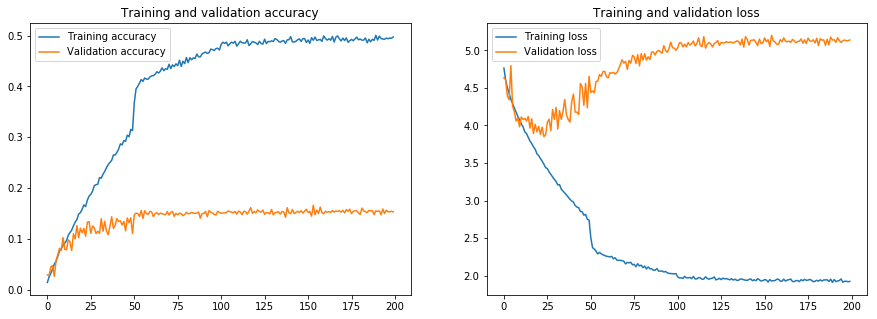

For alpha = 0.125:
 Max test accuracy = 0.152



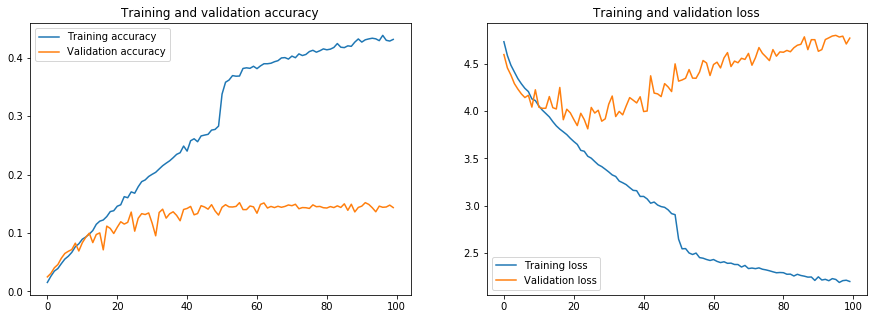

For alpha = 0.25:
 Max test accuracy = 0.152



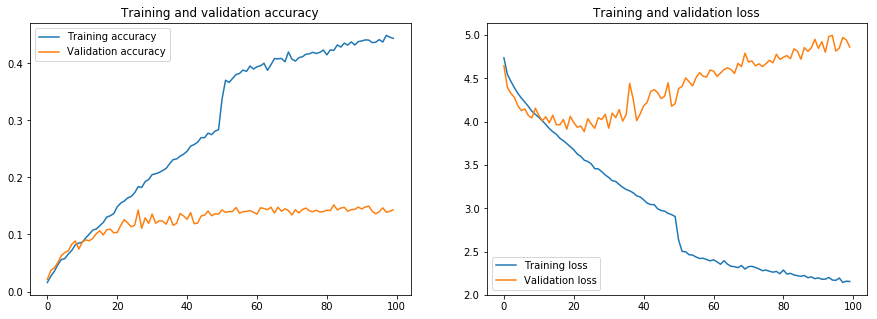

For alpha = 0.5:
 Max test accuracy = 0.1292



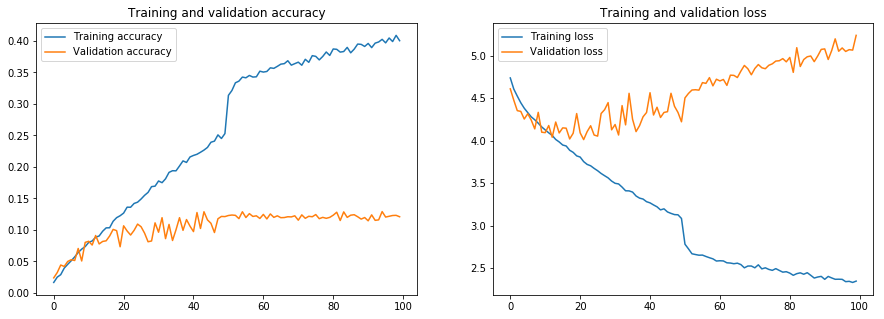

For alpha = 0.75:
 Max test accuracy = 0.1292



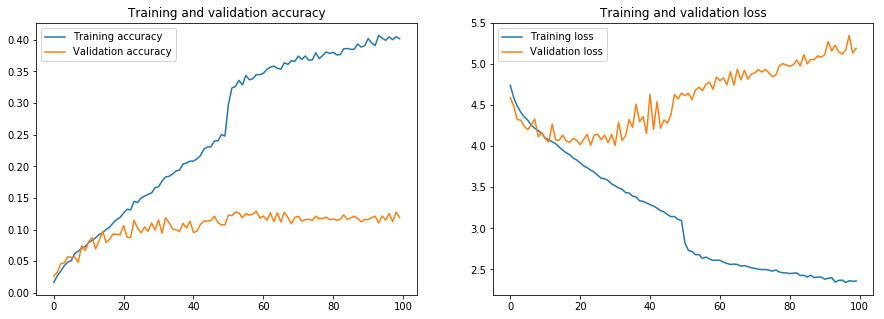

In [47]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_dogs_alpha_{alpha}_history_test', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

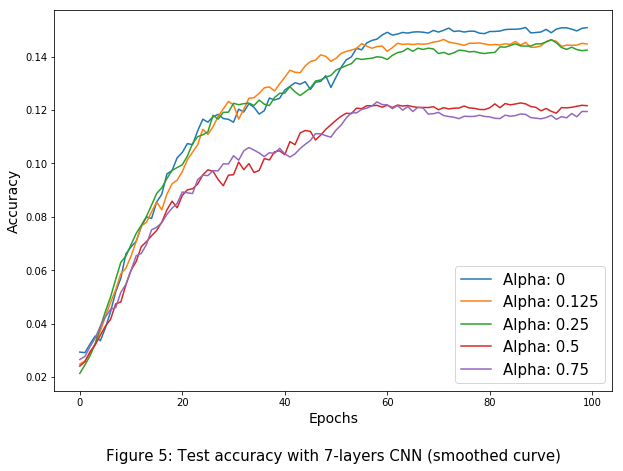

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_dogs_alpha_{alpha}_history_test', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc'][:100]), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 5: Test accuracy with 7-layers CNN (smoothed curve)", size=15, y=-.2)
ax.legend(prop={'size': 15})

plt.show()